# Spaceship Titanic

- 첫 시도
    - tensorflow를 이용해 활성화함수가 `sigmoid`인 `Dense Layer`을 1개 쌓아 모델을 만들고 손실함수는 `binary cross entropy` 함수, optimizer는`adam`를 이용하였음.
    - 잘 작동하며 결과도 잘 나왔으나 한계점이 분명함. 하이퍼파라미터를 아무리 변경해보아도 val_accuray 기준 0.7~0.8 이상은 절대 안 올라감. 즉 과소적합등의 문제가 아니라 모델 자체의 한계점으로 보임

## Import modules

In [1]:
import os
from datetime import datetime
from zipfile import ZipFile
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2023-12-16 12:51:14.151788: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-16 12:51:14.354539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 12:51:14.354575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 12:51:14.388711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 12:51:14.465586: I tensorflow/core/platform/cpu_feature_guar

## Set envs

In [2]:
PATH_INPUT = './data/in/'
PATH_OUTPUT = './data/out/'
NOW_STR = datetime.now().strftime('%Y%m%d_%H%M%S')
PATH_OUTPUT_NOW = f'./data/out/{NOW_STR}/'

try:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]
    )
except:
    print("NO GPU")

2023-12-16 12:51:16.226793: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 12:51:16.324700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 12:51:16.324748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Check Data

### Get Data

In [3]:
with ZipFile(PATH_INPUT + 'spaceship-titanic.zip') as f:
    print(f.namelist())

    df_train = pd.read_csv(BytesIO(f.read('train.csv')))
    df_test = pd.read_csv(BytesIO(f.read('test.csv')))
    df_sample = pd.read_csv(BytesIO(f.read('sample_submission.csv')))

['sample_submission.csv', 'test.csv', 'train.csv']


### Print Data

In [4]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
df_sample.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


- 목표<br>
3개 데이터를 비교한 결과 PassengerId는 key값이며 다른 여러 값들을 학습시켜 Transported를 유추해야함을 파악할 수 있다.<br>
학습 데이터가 주어져있으며, 종속변수는 한 개인 점, Transported값이 True, False 두개로 분리되어있다.<br>
따라서 이는 `이진분류`문제이다.<br><br>--> 활성화함수를 Sigmoid로 사용하여 학습하는 것이 좋겠다<br>

## Data Preprocessing

In [7]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Delete Null Data

In [9]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

- HomePlanet,CryoSleep,Cabin,Destination,VIP: null -> delete

In [10]:
df_train.dropna(subset=['HomePlanet','CryoSleep','Cabin','Destination','VIP'], inplace=True)

- Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck: null -> most frequency

In [11]:
columns = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for col in columns:
    most_freq = df_train[col].mode()[0]
    df_train[col].fillna(value=most_freq, inplace=True)

### Data Bias

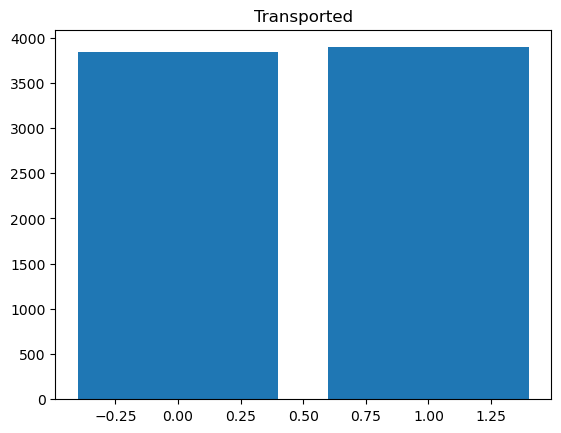

In [12]:
x = df_train['Transported'].unique()
y = [ len(df_train[df_train['Transported'] == i]) for i in x ]
plt.title('Transported')
plt.bar(x,y)
plt.show()

### String Data

In [13]:
non_num = ['HomePlanet', 'Cabin', 'Destination']
for col in non_num:
    uniq = df_train[col].unique()
    print("{0:=^40}".format(col))
    print(f'{uniq}  ({len(uniq)})')

===============HomePlanet===============
['Europa' 'Earth' 'Mars']  (3)
=================Cabin==================
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']  (6068)
==============Destination===============
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']  (3)


-> HomePlanet, Destination : One-hot Encoding

In [14]:
df_train = pd.get_dummies(df_train, columns=['HomePlanet', 'Destination'], dtype=int)

-> Cabin: Label Encoding

In [15]:
vocab = {
    "Cabin": {}
}

cabin_uniq = df_train['Cabin'].unique()
for idx,val in enumerate(cabin_uniq):
    vocab['Cabin'][val] = idx

df_train['Cabin'] = df_train['Cabin'].map(lambda v: vocab['Cabin'][v])

-> CryoSleep, VIP, Transported: Label Encoding (True: 1, False: 0)

In [16]:
df_train["CryoSleep"] = df_train["CryoSleep"].astype(int)
df_train["VIP"] = df_train["VIP"].astype(int)
df_train["Transported"] = df_train["Transported"].astype(int)

In [17]:
df_train

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0001_01,0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,0,0,1
1,0002_01,0,1,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,0,0,0,0,1
2,0003_01,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,0,0,0,1
3,0003_02,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,0,0,0,1
4,0004_01,0,3,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,6064,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,0,1,0,1,0,0
8689,9278_01,1,6065,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,1,0,0,0,1,0
8690,9279_01,0,6066,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,1,0,0,0,0,1
8691,9280_01,0,6067,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,0,1,0,1,0,0


## Train

### Set Input data

In [18]:
exception_cols = ['PassengerId', 'Name']
dependants = ['Transported']
independents = [ i for i in df_train.keys() if i not in dependants and i not in exception_cols ]
# 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'

X = df_train[independents]
Y = df_train[dependants]

In [19]:
X.shape, Y.shape

((7736, 15), (7736, 1))

### Build model

In [20]:
model = tf.keras.Sequential([
    Input(shape=[len(independents)]),
    Dense(128, activation="sigmoid"),
    Dense(64, activation="sigmoid"),
    Dense(32, activation="sigmoid"),
    Dense(16, activation="sigmoid"),
    Dense(len(dependants), activation="sigmoid")
])

2023-12-16 12:51:16.804543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 12:51:16.804705: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 12:51:16.804733: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 12:51:18.320438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-16 12:51:18.320458: I tensorflow/core/common_runtime/gpu/gpu

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12929 (50.50 KB)
Trainable params: 12929 (50.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
optimizer = tf.keras.optimizers.Adam()

model.compile(
    loss=BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy']
)

### Callback Functions

In [23]:
cb_earlystopping = EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=20)

chkpoint_path = f'./data/out/{NOW_STR}/monitor/'
if not os.path.exists(chkpoint_path):
    os.makedirs(chkpoint_path)

chkpoint_path += 'weights.h5'

cb_chkpoint = ModelCheckpoint(chkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

### Train model

#### Set Hyper-parameter

In [24]:
hyper_param = {
    "epochs": 200,
    "batch_size": 16,
    "validation_split": 0.1
}

#### Train

In [25]:
history = model.fit(
    X,
    Y,
    epochs=hyper_param['epochs'],
    batch_size=hyper_param['batch_size'],
    verbose=1,
    validation_split=hyper_param['validation_split'],
    callbacks=[cb_earlystopping, cb_chkpoint]
)

Epoch 1/200


2023-12-16 12:51:20.896211: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fabc01637f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-16 12:51:20.896245: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-12-16 12:51:20.908317: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-16 12:51:21.253713: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1702698681.311163    2314 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


427/436 [============================>.] - ETA: 0s - loss: 0.5730 - accuracy: 0.7187
Epoch 1: val_accuracy improved from -inf to 0.78553, saving model to ./data/out/20231216_125116/monitor/weights.h5
436/436 [==============================] - 6s 5ms/step - loss: 0.5717 - accuracy: 0.7198 - val_loss: 0.5010 - val_accuracy: 0.7855
Epoch 2/200
429/436 [============================>.] - ETA: 0s - loss: 0.4979 - accuracy: 0.7837
Epoch 2: val_accuracy did not improve from 0.78553
436/436 [==============================] - 3s 6ms/step - loss: 0.4967 - accuracy: 0.7848 - val_loss: 0.5069 - val_accuracy: 0.7571
Epoch 3/200
432/436 [============================>.] - ETA: 0s - loss: 0.4979 - accuracy: 0.7860
Epoch 3: val_accuracy improved from 0.78553 to 0.78811, saving model to ./data/out/20231216_125116/monitor/weights.h5
436/436 [==============================] - 3s 8ms/step - loss: 0.4980 - accuracy: 0.7860 - val_loss: 0.4905 - val_accuracy: 0.7881
Epoch 4/200
433/436 [=======================

## Result

### Model history graph

In [26]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

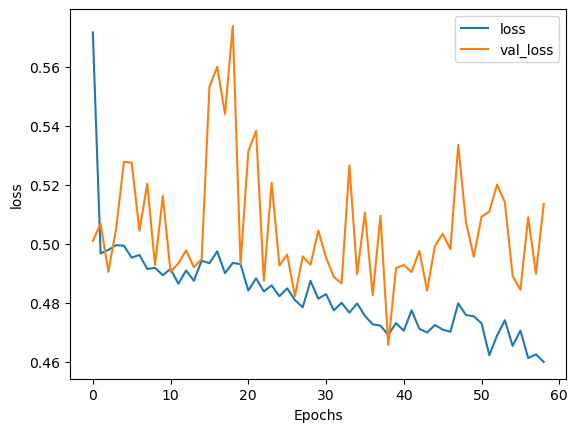

In [27]:
plot_graphs(history, 'loss')

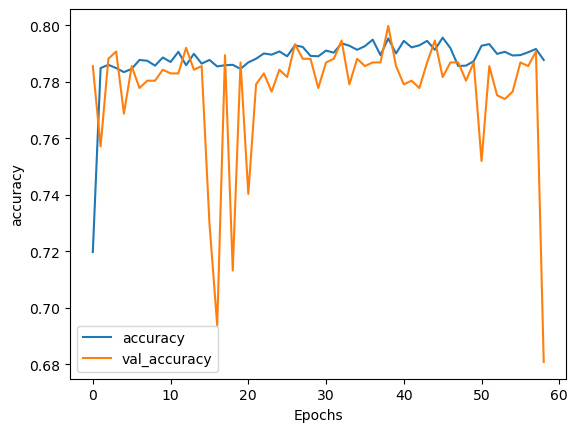

In [28]:
plot_graphs(history, 'accuracy')

### Save result data

In [29]:
data_out_path = f'./data/out/{NOW_STR}/'

if not os.path.exists(data_out_path):
    os.makedirs(data_out_path)

model.load_weights(os.path.join(data_out_path, "monitor", "weights.h5"))
model.save(os.path.join(data_out_path, "models", "model.h5"))

/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Validation

### Predict

In [30]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


### Preprocess test data

- HomePlanet, Destination: One-hot Encoding

In [31]:
df_test = pd.get_dummies(df_test, columns=['HomePlanet', 'Destination'], dtype=int)

- Cabin: Label Encoding

In [32]:
# 훈련 당시에 정한 사전 그대로 이용
for idx,val in enumerate(df_test['Cabin'].unique()):
    if val not in vocab['Cabin'].keys():
        vocab['Cabin'][val] = idx

df_test['Cabin'] = df_test['Cabin'].map(lambda v: vocab['Cabin'][v])

- CryoSleep, VIP, Transported: Label Encoding (True: 1, False: 0)

In [33]:
df_test["CryoSleep"] = df_test["CryoSleep"].map(lambda v: 1 if v else 0)
df_test["VIP"] = df_test["VIP"].map(lambda v: 1 if v else 0)

In [34]:
df_test.head()

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0013_01,1,0,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,1,0,0,0,0,1
1,0018_01,0,1,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,1,0,0,0,0,1
2,0019_01,1,2,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0,1,0,1,0,0
3,0021_01,0,3,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0,1,0,0,0,1
4,0023_01,0,4,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,1,0,0,0,0,1


In [35]:
predictions = model.predict(df_test[independents], batch_size=hyper_param['batch_size'])

268/268 [==============================] - 1s 3ms/step


#### Export prediction to csv file

##### Set Result Data

In [36]:
# 1에 가까우면 -> True, 0에 가까우면 False
predictions = list(map(lambda v: True if v[0] > 0.5 else False, predictions))

In [37]:
output = pd.DataFrame({ "PassengerId": df_test['PassengerId'].to_list(), "Transported": predictions })
output_dir = os.path.join(PATH_OUTPUT_NOW, "predict")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output.to_csv(os.path.join(output_dir, 'predict.csv'), index=False)